In [1]:
from math import sqrt
import re
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
from pylab import * 
from itertools import product 


/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib-1.5.1+1724.g35e2781-py3.4-linux-x86_64.egg/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
ls = range(1,6) #length of kmer
ys = [1, 2, 4, 5, 6, 10, 15] #some threshold
region = "data/region25_out/region25"

### Run profile kernel

In [3]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !profkernel-core -o {region}.idfile -K -L {l} -Y {y} -i /usr/share/fastprofkernel/data/Amino.txt -g /usr/share/fastprofkernel/data/Globals.txt {region}.kernelinput > {region}_L{l}_Y{y}.mat 2> {region}_L{l}_Y{y}.mat.log  

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### Adding row/col counts to the matrices

In [4]:
row_count = !wc -l {region}_L{ls[0]}_Y{ys[0]}.mat 
row_count = int(row_count[0].split(" ")[0])
row_count

1098

In [5]:
for l, y in product(ls, ys):
    !echo "{row_count} {row_count}\n$(cat {region}_L{l}_Y{y}.mat)" > {region}_L{l}_Y{y}.2.mat

### Execute weka

In [6]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -t {region}.arff -x 5 -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M {region}_L{l}_Y{y}.2.mat" > {region}_L{l}_Y{y}.weka

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### extract confusion matrix from WEKA

In [4]:
perf_dict = {}
for l, y in product(ls, ys):
    file = "{}_L{}_Y{}.weka".format(region, l, y)
    matrix = []
    with open(file) as f: 
        isMatrix = False
        isCV = False
        for line in f.readlines():         
            if line.startswith("=== Stratified cross-validation"):
                isCV = True
            if isCV and line.startswith("=== Confusion Matrix"):
                isMatrix = True
            if isMatrix and isCV: 
                matrix.append(line)
    pos = matrix[3].split("|")[0].strip()
    neg = matrix[4].split("|")[0].strip()
    TP, FN = (int(x.strip()) for x in pos.split())
    FP, TN = (int(x.strip()) for x in neg.split())
    perf_dict[(l, y)] = (TP, FN, FP, TN)

### compare the parameters
#### Which measure to use?
* Accuracy: bad because data is unbalanced
* F-Measure: hard to interpret intuitievely
* MCC: good, easy to interpret and balanced
* Sensistivity, Specificity: good, give the user information about what they actually expect from the predictor

In [5]:
def mcc(TP, FN, FP, TN): 
    return np.divide(TP * TN + FP * FN, sqrt( (TP+FP) * (TP+FN) * (TN+FP) * (TN+FN)))

def sens(TP, FN, FP, TN):
    return TP / (TP + FN)

def spec(TP, FN, FP, TN):
    return TN / (TN + FP)

def prec_pos(TP, FN, FP, TN):
    return np.divide(TP, (TP + FP))
def recall_pos(TP, FN, FP, TN):
    return np.divide(TP, (TP + FN))
def prec_neg(TP, FN, FP, TN):
    return np.divide(TN, (TN + FN))
def recall_neg(TP, FN, FP, TN):
    return np.divide(TN, (TN + FP))

def f1_pos(TP, FN, FP, TN):
    return np.divide(2 * prec_pos(TP, FN, FP, TN) * recall_pos(TP, FN, FP, TN),
                     (prec_pos(TP, FN, FP, TN) + recall_pos(TP, FN, FP, TN)))
def f1_neg(TP, FN, FP, TN):
    return np.divide(2 * prec_neg(TP, FN, FP, TN) * recall_neg(TP, FN, FP, TN),
                     (prec_neg(TP, FN, FP, TN) + recall_neg(TP, FN, FP, TN)))

In [10]:
def make_df(f):
    f_dict = {}
    for y in ys:
        f_dict[y] = {}
        for l in ls:
            f_dict[y][l] = f(*perf_dict[l, y])
    return pd.DataFrame(f_dict)

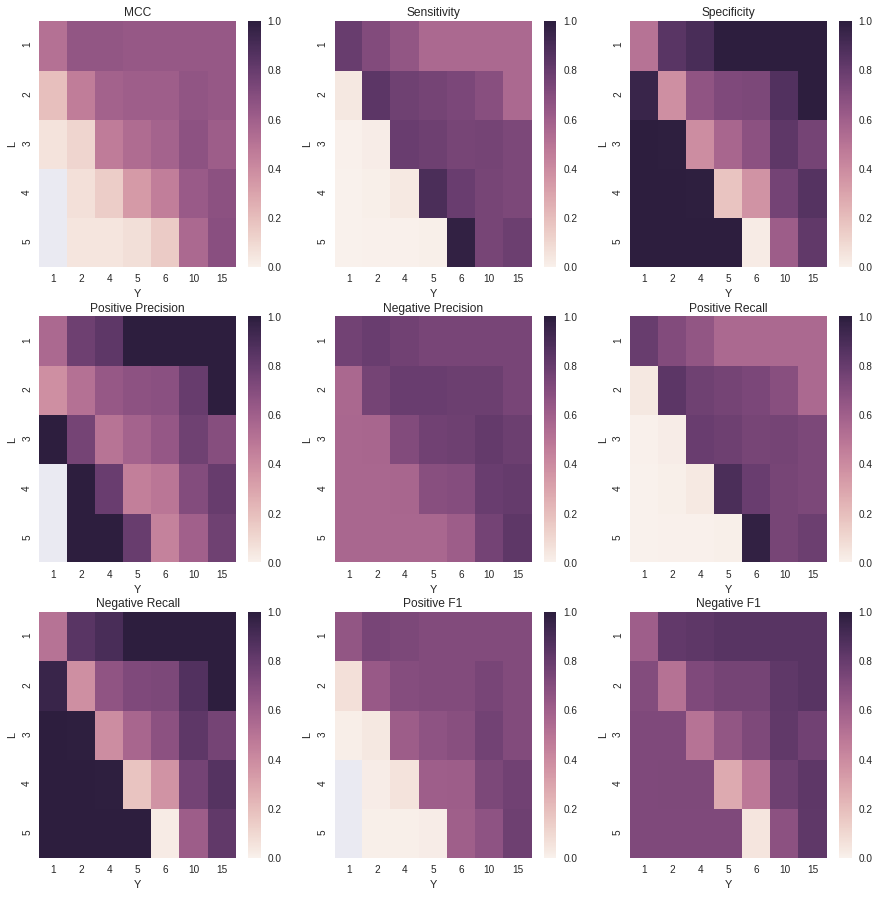

In [32]:
fig, grid = subplots(3, 3, figsize=(15, 15))

sns.heatmap(make_df(mcc), ax=grid[0][0], vmin=0, vmax=1)
grid[0][0].set_title("MCC")

sns.heatmap(make_df(sens), ax=grid[0][1], vmin=0, vmax=1)
grid[0][1].set_title("Sensitivity")

sns.heatmap(make_df(spec), ax=grid[0][2], vmin=0, vmax=1)
grid[0][2].set_title("Specificity")

sns.heatmap(make_df(prec_pos), ax=grid[1][0], vmin=0, vmax=1)
grid[1][0].set_title("Positive Precision")

sns.heatmap(make_df(prec_neg), ax=grid[1][1], vmin=0, vmax=1)
grid[1][1].set_title("Negative Precision")

sns.heatmap(make_df(recall_pos), ax=grid[1][2], vmin=0, vmax=1)
grid[1][2].set_title("Positive Recall")

sns.heatmap(make_df(recall_neg), ax=grid[2][0], vmin=0, vmax=1)
grid[2][0].set_title("Negative Recall")

sns.heatmap(make_df(f1_pos), ax=grid[2][1], vmin=0, vmax=1)
grid[2][1].set_title("Positive F1")

sns.heatmap(make_df(f1_neg), ax=grid[2][2], vmin=0, vmax=1)
grid[2][2].set_title("Negative F1")


for ax in grid.flatten():
    ax.set_xlabel("Y")
    ax.set_ylabel("L")
    
fig.savefig("wiki/eval25.png")

In [12]:
make_df(mcc)

,1,2,4,5,6,10,15
1,0.515340,0.653199,0.649868,0.639582,0.639582,0.639582,0.639582
2,0.198221,0.462372,0.586005,0.606220,0.606613,0.656877,0.639582
3,0.059502,0.111871,0.468689,0.541367,0.584341,0.669664,0.613651
4,NaN,0.068738,0.142128,0.341524,0.458904,0.625985,0.676635
5,NaN,0.048561,0.048561,0.073210,0.148877,0.553933,0.683682


In [33]:
make_df(sens)

,1,2,4,5,6,10,15
1,0.797495,0.707724,0.651357,0.551148,0.551148,0.551148,0.551148
2,0.037578,0.837161,0.776618,0.751566,0.736952,0.693111,0.551148
3,0.006263,0.018789,0.791232,0.778706,0.749478,0.751566,0.728601
4,0.000000,0.008351,0.031315,0.897704,0.795407,0.749478,0.730689
5,0.000000,0.004175,0.004175,0.008351,0.979123,0.747390,0.784969


In [34]:
make_df(spec)

,1,2,4,5,6,10,15
1,0.504039,0.846527,0.899838,1.000000,1.000000,1.000000,1.000000
2,0.953150,0.384491,0.662359,0.720517,0.733441,0.867528,1.000000
3,1.000000,0.995153,0.394184,0.568659,0.678514,0.831987,0.754443
4,1.000000,1.000000,0.993538,0.174475,0.369952,0.759289,0.862682
5,1.000000,1.000000,1.000000,0.998384,0.025848,0.613893,0.823910


In [13]:
make_df(prec_pos)

,1,2,4,5,6,10,15
1,0.554427,0.781106,0.834225,1.000000,1.000000,1.000000,1.000000
2,0.382979,0.512788,0.640275,0.675422,0.681467,0.801932,1.000000
3,1.000000,0.750000,0.502653,0.582812,0.643369,0.775862,0.696607
4,NaN,1.000000,0.789474,0.456961,0.494163,0.706693,0.804598
5,NaN,1.000000,1.000000,0.800000,0.437500,0.599665,0.775258


In [14]:
make_df(prec_neg)

,1,2,4,5,6,10,15
1,0.762836,0.789157,0.769337,0.742206,0.742206,0.742206,0.742206
2,0.561370,0.753165,0.793037,0.789381,0.782759,0.785088,0.742206
3,0.565297,0.567219,0.709302,0.768559,0.777778,0.812303,0.782245
4,0.563752,0.565814,0.569972,0.687898,0.700306,0.796610,0.805430
5,0.563752,0.564781,0.564781,0.565416,0.615385,0.758483,0.831974


In [15]:
make_df(recall_pos)

,1,2,4,5,6,10,15
1,0.797495,0.707724,0.651357,0.551148,0.551148,0.551148,0.551148
2,0.037578,0.837161,0.776618,0.751566,0.736952,0.693111,0.551148
3,0.006263,0.018789,0.791232,0.778706,0.749478,0.751566,0.728601
4,0.000000,0.008351,0.031315,0.897704,0.795407,0.749478,0.730689
5,0.000000,0.004175,0.004175,0.008351,0.979123,0.747390,0.784969


In [16]:
make_df(recall_neg)

,1,2,4,5,6,10,15
1,0.504039,0.846527,0.899838,1.000000,1.000000,1.000000,1.000000
2,0.953150,0.384491,0.662359,0.720517,0.733441,0.867528,1.000000
3,1.000000,0.995153,0.394184,0.568659,0.678514,0.831987,0.754443
4,1.000000,1.000000,0.993538,0.174475,0.369952,0.759289,0.862682
5,1.000000,1.000000,1.000000,0.998384,0.025848,0.613893,0.823910


In [18]:
make_df(f1_pos)

,1,2,4,5,6,10,15
1,0.654110,0.742607,0.731536,0.710633,0.710633,0.710633,0.710633
2,0.068441,0.636003,0.701887,0.711462,0.708124,0.743561,0.710633
3,0.012448,0.036660,0.614761,0.666667,0.692382,0.763521,0.712245
4,NaN,0.016563,0.060241,0.605634,0.609600,0.727457,0.765864
5,NaN,0.008316,0.008316,0.016529,0.604771,0.665428,0.780083


In [19]:
make_df(f1_neg)

,1,2,4,5,6,10,15
1,0.607004,0.816836,0.829486,0.852030,0.852030,0.852030,0.852030
2,0.706587,0.509091,0.721831,0.753378,0.757298,0.824252,0.852030
3,0.722287,0.722581,0.506750,0.653668,0.724763,0.822027,0.768092
4,0.721025,0.722709,0.724382,0.278351,0.484144,0.777502,0.833073
5,0.721025,0.721866,0.721866,0.721963,0.049612,0.678571,0.827922
